In [28]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import os

%matplotlib inline

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

In [30]:
data_vec_str = ['center_surround', 'spiral', 'two_gaussians', 'xor']
data_vec = [[pd.read_csv(f'{data}_train.csv'), pd.read_csv(f'{data}_valid.csv'), pd.read_csv(f'{data}_test.csv')] for data in data_vec_str]

In [31]:
class Data(Dataset):
  def __init__(self, data, targets):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.labels = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

class FeedForward(nn.Module):
  def __init__(self, size_in, size_out, k, device=device):
    super(FeedForward, self).__init__()
    self.linearStack = nn.Sequential(
        nn.Linear(size_in, k),
        nn.Tanh(),
        nn.Linear(k, size_out),
        nn.Tanh()
    )
  
  def forward(self, x):
    x = self.linearStack(x)
    return x
  
def train_model(model, dataloader, criterion, optimizer, device):
  model.train()
  tot_train_loss = 0
  for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data).squeeze()
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      tot_train_loss += loss.item()
  return tot_train_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  targets = []
  predictions = []
  total_loss = 0
  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data).squeeze()
          loss = criterion(output, target)
          total_loss += loss.item()
          predictions.extend(output.cpu().numpy())
          targets.extend(target.cpu().numpy())
  # Calculate binary classification metrics
  predictions = np.array(predictions) > 0.5  # Threshold at 0.5
  accuracy = accuracy_score(targets, predictions)
  avg_loss = total_loss / len(dataloader)
  return predictions, accuracy, avg_loss

def process_data(train_df, valid_df, test_df, batch_size, shuffle):
  # set up data
  train_data_df = train_df.loc[:, train_df.columns != 'label']
  train_target_df = train_df['label']
  valid_data_df = valid_df.loc[:, valid_df.columns != 'label']
  valid_target_df = valid_df['label']
  test_data_df = test_df.loc[:, test_df.columns != 'label']
  test_target_df = test_df['label']

  len_features = len(train_data_df.columns)

  # fit and transform data
  sc = StandardScaler()
  train_data_df = sc.fit_transform(train_data_df)
  test_data_df = sc.transform(test_data_df)
  valid_data_df = sc.transform(valid_data_df)

  # set up and implement data loaders
  train_data = Data(train_data_df, train_target_df)
  valid_data = Data(valid_data_df, valid_target_df)
  test_data = Data(test_data_df, test_target_df)
  train_loader = DataLoader(train_data, batch_size, shuffle)
  valid_loader = DataLoader(valid_data, batch_size, shuffle)
  test_loader = DataLoader(test_data, batch_size, shuffle)

  return train_loader, valid_loader, test_loader, len_features, test_data_df, test_target_df

In [32]:
data_params = {
    'center_surround': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 200
    },
    'spiral': {
        'batch_size': 100,
        'shuffle': True,
        'k': 9,
        'lr': 1e-2,
        'epochs': 400
    },
    'two_gaussians': {
        'batch_size': 100,
        'shuffle': True,
        'k': 3,
        'lr': 1e-2,
        'epochs': 100
    },
    'xor': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 300
    }
} # k = {2, 3, 5, 7, 9}

Training on center_surround data
Training on spiral data
Training on two_gaussians data
Training on xor data


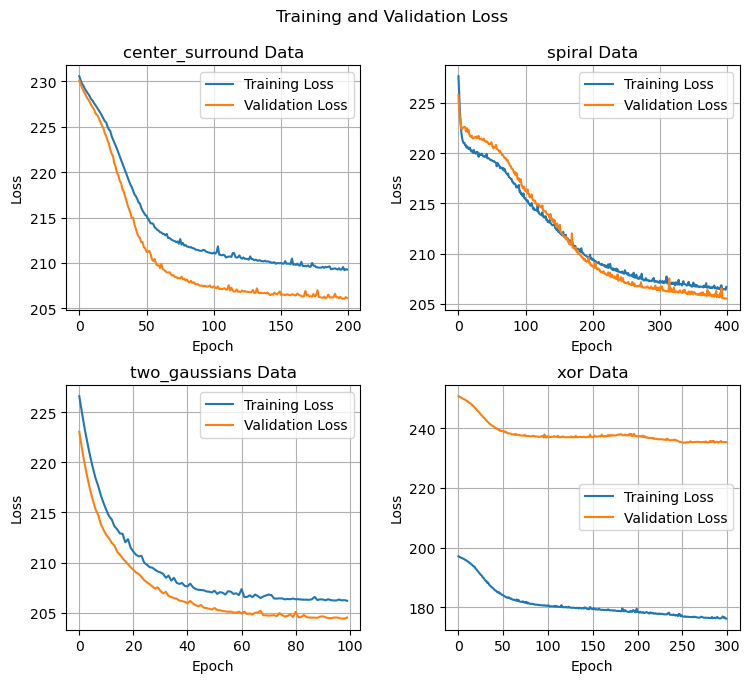

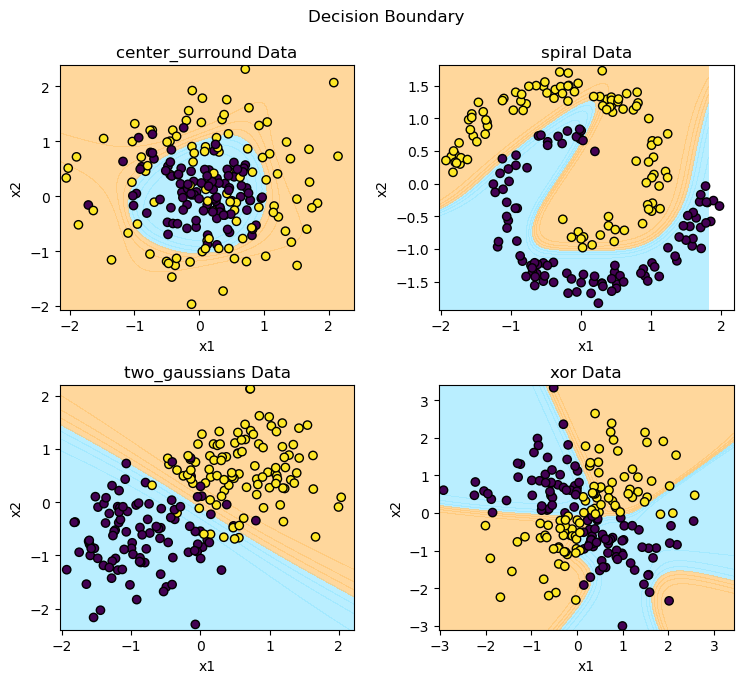

,Data,Accuracy,Loss,Batch Size,Shuffle,k,Learning Rate,Epochs
0,center_surround,0.750,222.048836,100,True,5,0.01,200
1,spiral,0.980,204.003540,100,True,9,0.01,400
2,two_gaussians,0.915,209.137764,100,True,3,0.01,100
3,xor,0.840,193.003448,100,True,5,0.01,300


In [33]:
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(8, 7))
fig_loss.suptitle('Training and Validation Loss')
fig_loss.tight_layout(pad=3.0)
fig_loss.subplots_adjust(top=0.90)

fig_decision, axes_decision = plt.subplots(2, 2, figsize=(8, 7))
fig_decision.suptitle('Decision Boundary')
fig_decision.tight_layout(pad=3.0)
fig_decision.subplots_adjust(top=0.90)

results = pd.DataFrame(columns=['Data', 'Accuracy', 'Loss', 'Batch Size', 'Shuffle', 'k', 'Learning Rate', 'Epochs'])


for idx in range(len(data_vec_str)):
    data_str = data_vec_str[idx]
    batch_size = data_params[data_str]['batch_size']
    shuffle = data_params[data_str]['shuffle']
    k = data_params[data_str]['k']
    lr = data_params[data_str]['lr']
    epochs = data_params[data_str]['epochs']
    print(f"Training on {data_str} data")
    
    # set up data
    train_loader, valid_loader, test_loader, len_features, test_data, test_target = \
        process_data(data_vec[idx][0], data_vec[idx][1], data_vec[idx][2], batch_size, shuffle)
    
    # set up model
    model = FeedForward(len_features, 1, k).to(device)
    loss_fun = nn.CrossEntropyLoss()#nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train model
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        avg_train_loss = train_model(model, train_loader, loss_fun, optimizer, device)    
        _, accuracy, avg_valid_loss = evaluate_model(model, valid_loader, loss_fun, device)
        training_loss.append(avg_train_loss)
        validation_loss.append(avg_valid_loss)
        # if epoch % 100 == 0:
        #     print(f'Epoch {epoch}: Validation Accuracy: {accuracy:.4f}')

    # Plot training and validation loss
    axes_loss[idx//2, idx%2].plot(training_loss, label='Training Loss')
    axes_loss[idx//2, idx%2].plot(validation_loss, label='Validation Loss')
    axes_loss[idx//2, idx%2].set_xlabel('Epoch')
    axes_loss[idx//2, idx%2].set_ylabel('Loss')
    axes_loss[idx//2, idx%2].legend()
    axes_loss[idx//2, idx%2].grid(True)
    axes_loss[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

    # Evaluate model
    predictions, accuracy, avg_test_loss = evaluate_model(model, test_loader, loss_fun, device)
    results.loc[idx] = [data_vec_str[idx], accuracy, avg_test_loss, batch_size, shuffle, k, lr, epochs]

    # Plot decision boundaries (assumes two features)
    min1, max1 = test_data[:, 0].min()-0.1, test_data[:, 1].max()+0.1
    min2, max2 = test_data[:, 1].min()-0.1, test_data[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.arange(min1, max1, 0.05), np.arange(min2, max2, 0.05))
    grid = np.c_[xx.ravel(), yy.ravel()]
    z = model(torch.tensor(grid, dtype=torch.float32).to(device)).detach().cpu().numpy()
    zz = z.reshape(xx.shape)

    binary_cmap = colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axes_decision[idx//2, idx%2].contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)
    axes_decision[idx//2, idx%2].scatter(test_data[:,0], test_data[:,1], c=test_target, edgecolor='k')
    axes_decision[idx//2, idx%2].set_xlabel('x1')
    axes_decision[idx//2, idx%2].set_ylabel('x2')
    axes_decision[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

plt.show()
display(results)

### Hyperparameters:
batch_size
shuffle
k (number of hidden nodes)
lr (learning rate)
epochs (number of training epochs)

### discuss your design choices and comment on how they impact performance
1. batch size

We set batch size to 100 for all datasets, to balance the run time and stability.
With larger batch size, it would result in a more stable model performance and a more accurate training loss. However, it may take a long time to run and requires a lot of memory space (If the batch is too large, the programme may crash).
With smaller batch size, it would result in faster trainning time and more efficient memory usage, but it would represent a unstable, inaccurate training loss.

2. shuffle

We choose to conduct random shuffling of the data set in order to make it more generalized.
Shuffling the data may cause the loss representation to be noisy. However, it helps to generalize the model.

3. number of hidden nodes k

We select k based on the validation performance of the model trained. 
With higher k, there would be more hidden nodes for the neural network to learn from the training data, which may allow the model to predict better, but also may cause overfitting on the training data and long running time for model training.

4. learning rate

We set learning rate to 1e-2 to balance between the convergence speed and noise rate.
With higher learning rate, the model may converge faster but with many noise. With lower learning rate, the model would converge stablely but slowly.

5. epochs ??


## MSE

In [34]:
class Data(Dataset):
  def __init__(self, data, targets):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.labels = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

class FeedForward(nn.Module):
  def __init__(self, size_in, size_out, k, device=device):
    super(FeedForward, self).__init__()
    self.linearStack = nn.Sequential(
        nn.Linear(size_in, k),
        nn.Tanh(),
        nn.Linear(k, size_out),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.linearStack(x)
    return x
  
def train_model(model, dataloader, criterion, optimizer, device):
  model.train()
  tot_train_loss = 0
  for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data).squeeze()
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      tot_train_loss += loss.item()
  return tot_train_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  targets = []
  predictions = []
  total_loss = 0
  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data).squeeze()
          loss = criterion(output, target)
          total_loss += loss.item()
          predictions.extend(output.cpu().numpy())
          targets.extend(target.cpu().numpy())
  # Calculate binary classification metrics
  predictions = np.array(predictions) > 0.5  # Threshold at 0.5
  accuracy = accuracy_score(targets, predictions)
  avg_loss = total_loss / len(dataloader)
  return predictions, accuracy, avg_loss

def process_data(train_df, valid_df, test_df, batch_size, shuffle):
  # set up data
  train_data_df = train_df.loc[:, train_df.columns != 'label']
  train_target_df = train_df['label']
  valid_data_df = valid_df.loc[:, valid_df.columns != 'label']
  valid_target_df = valid_df['label']
  test_data_df = test_df.loc[:, test_df.columns != 'label']
  test_target_df = test_df['label']

  len_features = len(train_data_df.columns)

  # fit and transform data
  sc = StandardScaler()
  train_data_df = sc.fit_transform(train_data_df)
  test_data_df = sc.transform(test_data_df)
  valid_data_df = sc.transform(valid_data_df)

  # set up and implement data loaders
  train_data = Data(train_data_df, train_target_df)
  valid_data = Data(valid_data_df, valid_target_df)
  test_data = Data(test_data_df, test_target_df)
  train_loader = DataLoader(train_data, batch_size, shuffle)
  valid_loader = DataLoader(valid_data, batch_size, shuffle)
  test_loader = DataLoader(test_data, batch_size, shuffle)

  return train_loader, valid_loader, test_loader, len_features, test_data_df, test_target_df

In [35]:
data_params = {
    'center_surround': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 400
    },
    'spiral': {
        'batch_size': 120,
        'shuffle': True,
        'k': 9,
        'lr': 1e-2,
        'epochs': 360
    },
    'two_gaussians': {
        'batch_size': 100,
        'shuffle': True,
        'k': 3,
        'lr': 1e-2,
        'epochs': 100
    },
    'xor': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 335
    }
} # k = {2, 3, 5, 7, 9}

Training on center_surround data
Training on spiral data
Training on two_gaussians data
Training on xor data


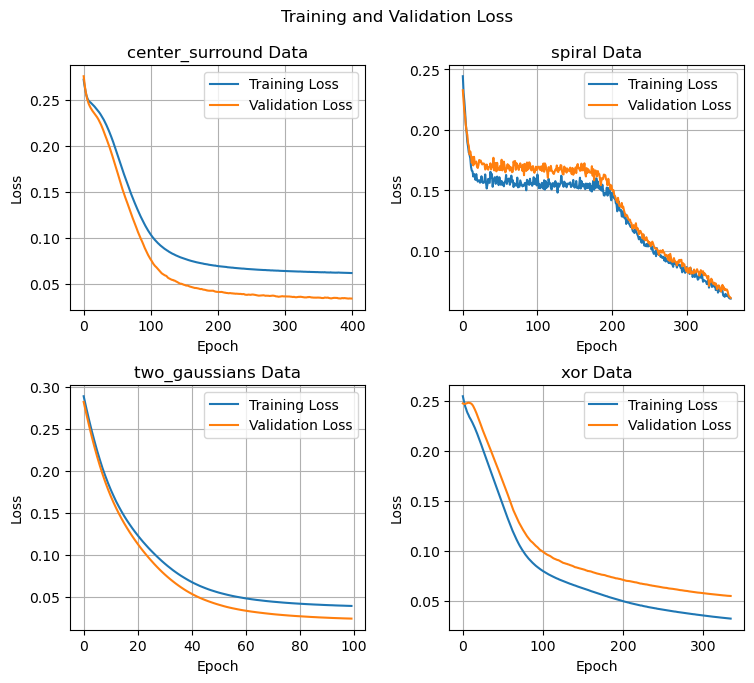

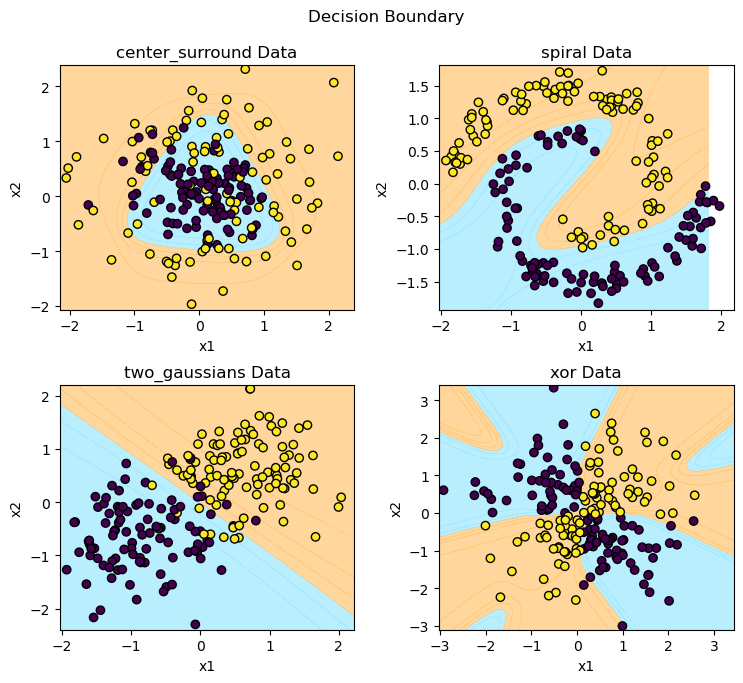

,Data,Accuracy,Loss,Batch Size,Shuffle,k,Learning Rate,Epochs
0,center_surround,0.750,0.199166,100,True,5,0.01,400
1,spiral,0.985,0.047820,120,True,9,0.01,360
2,two_gaussians,0.915,0.060212,100,True,3,0.01,100
3,xor,0.945,0.045891,100,True,5,0.01,335


In [36]:
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(8, 7))
fig_loss.suptitle('Training and Validation Loss')
fig_loss.tight_layout(pad=3.0)
fig_loss.subplots_adjust(top=0.90)

fig_decision, axes_decision = plt.subplots(2, 2, figsize=(8, 7))
fig_decision.suptitle('Decision Boundary')
fig_decision.tight_layout(pad=3.0)
fig_decision.subplots_adjust(top=0.90)

results = pd.DataFrame(columns=['Data', 'Accuracy', 'Loss', 'Batch Size', 'Shuffle', 'k', 'Learning Rate', 'Epochs'])


for idx in range(len(data_vec_str)):
    data_str = data_vec_str[idx]
    batch_size = data_params[data_str]['batch_size']
    shuffle = data_params[data_str]['shuffle']
    k = data_params[data_str]['k']
    lr = data_params[data_str]['lr']
    epochs = data_params[data_str]['epochs']
    print(f"Training on {data_str} data")
    
    # set up data
    train_loader, valid_loader, test_loader, len_features, test_data, test_target = \
        process_data(data_vec[idx][0], data_vec[idx][1], data_vec[idx][2], batch_size, shuffle)
    
    # set up model
    model = FeedForward(len_features, 1, k).to(device)
    loss_fun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train model
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        avg_train_loss = train_model(model, train_loader, loss_fun, optimizer, device)    
        _, accuracy, avg_valid_loss = evaluate_model(model, valid_loader, loss_fun, device)
        training_loss.append(avg_train_loss)
        validation_loss.append(avg_valid_loss)
        # if epoch % 100 == 0:
        #     print(f'Epoch {epoch}: Validation Accuracy: {accuracy:.4f}')

    # Plot training and validation loss
    axes_loss[idx//2, idx%2].plot(training_loss, label='Training Loss')
    axes_loss[idx//2, idx%2].plot(validation_loss, label='Validation Loss')
    axes_loss[idx//2, idx%2].set_xlabel('Epoch')
    axes_loss[idx//2, idx%2].set_ylabel('Loss')
    axes_loss[idx//2, idx%2].legend()
    axes_loss[idx//2, idx%2].grid(True)
    axes_loss[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

    # Evaluate model
    predictions, accuracy, avg_test_loss = evaluate_model(model, test_loader, loss_fun, device)
    results.loc[idx] = [data_vec_str[idx], accuracy, avg_test_loss, batch_size, shuffle, k, lr, epochs]

    # Plot decision boundaries (assumes two features)
    min1, max1 = test_data[:, 0].min()-0.1, test_data[:, 1].max()+0.1
    min2, max2 = test_data[:, 1].min()-0.1, test_data[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.arange(min1, max1, 0.05), np.arange(min2, max2, 0.05))
    grid = np.c_[xx.ravel(), yy.ravel()]
    z = model(torch.tensor(grid, dtype=torch.float32).to(device)).detach().cpu().numpy()
    zz = z.reshape(xx.shape)

    binary_cmap = colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axes_decision[idx//2, idx%2].contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)
    axes_decision[idx//2, idx%2].scatter(test_data[:,0], test_data[:,1], c=test_target, edgecolor='k')
    axes_decision[idx//2, idx%2].set_xlabel('x1')
    axes_decision[idx//2, idx%2].set_ylabel('x2')
    axes_decision[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

plt.show()
display(results)

## Q3 without deep learning platform

In [14]:
np.random.seed(42)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(a):
    return 1 - np.tanh(a) ** 2

## MCE Manual

In [15]:
class FeedForward:
    def __init__(self, size_in, size_out, k):
        # Initialize weights and biases similar to PyTorch
        self.W1 = np.random.randn(k, size_in) * np.sqrt(1 / size_in)
        self.b1 = np.zeros((k, 1))
        self.W2 = np.random.randn(size_out, k) * np.sqrt(1 / k)
        self.b2 = np.zeros((size_out, 1))

        # Simulating Adam optimizer
        self.mW1 = np.zeros_like(self.W1)
        self.vW1 = np.zeros_like(self.W1)
        self.mb1 = np.zeros_like(self.b1)
        self.vb1 = np.zeros_like(self.b1)
        self.mW2 = np.zeros_like(self.W2)
        self.vW2 = np.zeros_like(self.W2)
        self.mb2 = np.zeros_like(self.b2)
        self.vb2 = np.zeros_like(self.b2)

    def forward(self, x):
        self.z1 = np.dot(self.W1, x) + self.b1
        self.a1 = tanh(self.z1)
        self.z2 = np.dot(self.W2, self.a1) + self.b2 
        self.y_hat = sigmoid(self.z2)
        return self.y_hat

# BCE loss
def compute_loss(y_hat, y):
    m = y.shape[1]
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss

def backward(model, x, y):
    m = y.shape[1]

    BCEderivative = - (1/m) * (y / model.y_hat - (1 - y) / (1 - model.y_hat))
    dz2 = BCEderivative * sigmoid_derivative(model.y_hat)
    dW2 = np.dot(dz2, model.a1.T)  
    db2 = np.sum(dz2, axis=1, keepdims=True)  

    # Backpropagate to first layer
    da1 = np.dot(model.W2.T, dz2)
    dz1 = da1 * tanh_derivative(model.a1)
    dW1 = np.dot(dz1, x.T)
    db1 = np.sum(dz1, axis=1, keepdims=True)

    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return grads

def update_parameters(model, grads, lr, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    #using gradient descent
    
    # For W1
    model.mW1 = beta1 * model.mW1 + (1 - beta1) * grads['dW1']
    model.vW1 = beta2 * model.vW1 + (1 - beta2) * (grads['dW1'] ** 2)
    mW1_hat = model.mW1 / (1 - beta1 ** t)
    vW1_hat = model.vW1 / (1 - beta2 ** t)
    model.W1 -= lr * mW1_hat / (np.sqrt(vW1_hat) + epsilon)

    # For b1
    model.mb1 = beta1 * model.mb1 + (1 - beta1) * grads['db1']
    model.vb1 = beta2 * model.vb1 + (1 - beta2) * (grads['db1'] ** 2)
    mb1_hat = model.mb1 / (1 - beta1 ** t)
    vb1_hat = model.vb1 / (1 - beta2 ** t)
    model.b1 -= lr * mb1_hat / (np.sqrt(vb1_hat) + epsilon)

    # For W2
    model.mW2 = beta1 * model.mW2 + (1 - beta1) * grads['dW2']
    model.vW2 = beta2 * model.vW2 + (1 - beta2) * (grads['dW2'] ** 2)
    mW2_hat = model.mW2 / (1 - beta1 ** t)
    vW2_hat = model.vW2 / (1 - beta2 ** t)
    model.W2 -= lr * mW2_hat / (np.sqrt(vW2_hat) + epsilon)

    # For b2
    model.mb2 = beta1 * model.mb2 + (1 - beta1) * grads['db2']
    model.vb2 = beta2 * model.vb2 + (1 - beta2) * (grads['db2'] ** 2)
    mb2_hat = model.mb2 / (1 - beta1 ** t)
    vb2_hat = model.vb2 / (1 - beta2 ** t)
    model.b2 -= lr * mb2_hat / (np.sqrt(vb2_hat) + epsilon)

def evaluate_model(model, data, target):
    x = data.T
    y = target.reshape(1, -1)
    y_hat = model.forward(x)
    predictions = y_hat > 0.5
    accuracy = np.mean(predictions == y)
    loss = compute_loss(y_hat, y)
    return accuracy, loss

def process_data(train_df, valid_df, test_df):
    # Extract features and labels
    train_data = train_df.loc[:, train_df.columns != 'label'].values
    train_target = train_df['label'].values
    valid_data = valid_df.loc[:, valid_df.columns != 'label'].values
    valid_target = valid_df['label'].values
    test_data = test_df.loc[:, test_df.columns != 'label'].values
    test_target = test_df['label'].values

    # Standardize the data
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    valid_data = scaler.transform(valid_data)
    test_data = scaler.transform(test_data)

    return train_data, train_target, valid_data, valid_target, test_data, test_target

# Manual Dataloader
def create_batches(data, targets, batch_size, shuffle=True):
    N = data.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    data_shuffled = data[indices]
    targets_shuffled = targets[indices]
    batches = []
    for i in range(0, N, batch_size):
        batch_data = data_shuffled[i:i+batch_size]
        batch_targets = targets_shuffled[i:i+batch_size]
        batches.append((batch_data, batch_targets))
    return batches


In [16]:
data_params = {
    'center_surround': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 200
    },
    'spiral': {
        'batch_size': 100,
        'shuffle': True,
        'k': 9,
        'lr': 1e-2,
        'epochs': 400
    },
    'two_gaussians': {
        'batch_size': 100,
        'shuffle': True,
        'k': 3,
        'lr': 1e-2,
        'epochs': 100
    },
    'xor': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 300
    }
} # k = {2, 3, 5, 7, 9}

Training on center_surround data
Training on spiral data
Training on two_gaussians data
Training on xor data


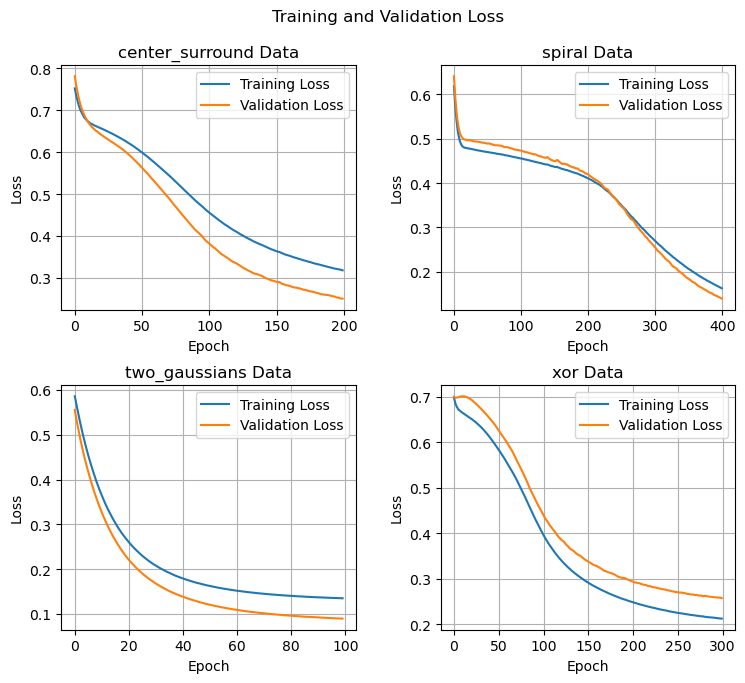

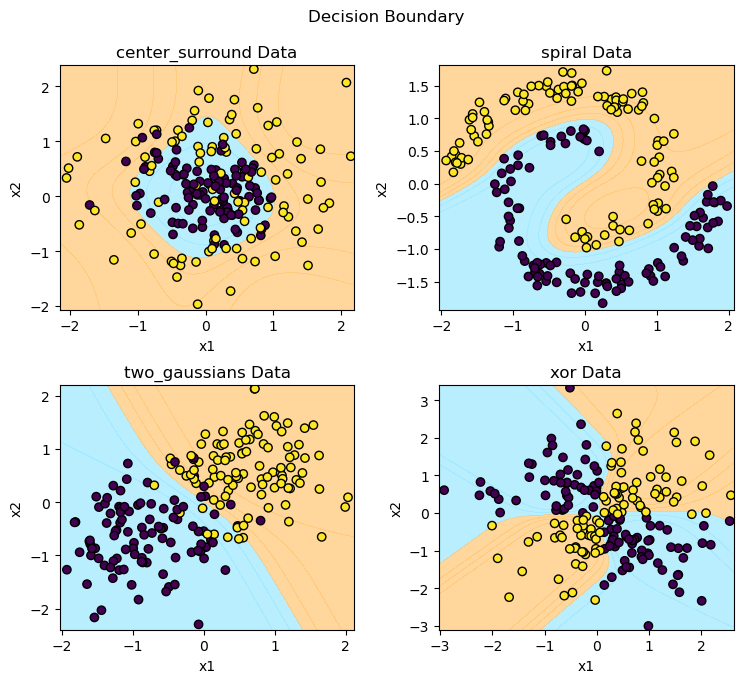

,Data,Accuracy,Loss,Batch Size,Shuffle,k,Learning Rate,Epochs
0,center_surround,0.73,0.536858,100,True,5,0.01,200
1,spiral,1.00,0.103814,100,True,9,0.01,400
2,two_gaussians,0.91,0.183343,100,True,3,0.01,100
3,xor,0.91,0.216251,100,True,5,0.01,300


In [17]:
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(8, 7))
fig_loss.suptitle('Training and Validation Loss')
fig_loss.tight_layout(pad=3.0)
fig_loss.subplots_adjust(top=0.90)

fig_decision, axes_decision = plt.subplots(2, 2, figsize=(8, 7))
fig_decision.suptitle('Decision Boundary')
fig_decision.tight_layout(pad=3.0)
fig_decision.subplots_adjust(top=0.90)

results = pd.DataFrame(columns=['Data', 'Accuracy', 'Loss', 'Batch Size', 'Shuffle', 'k', 'Learning Rate', 'Epochs'])

for idx in range(len(data_vec_str)):
    data_str = data_vec_str[idx]
    batch_size = data_params[data_str]['batch_size']
    shuffle = data_params[data_str]['shuffle']
    k = data_params[data_str]['k']
    lr = data_params[data_str]['lr']
    epochs = data_params[data_str]['epochs']
    print(f"Training on {data_str} data")
    
    # Process data
    train_data, train_target, valid_data, valid_target, test_data, test_target = process_data(
        data_vec[idx][0], data_vec[idx][1], data_vec[idx][2]
    )

    # Initialize manual model
    size_in = train_data.shape[1]
    size_out = 1
    model_manual = FeedForward(size_in, size_out, k)

    # Training
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        # Create batches for training
        train_batches = create_batches(train_data, train_target, batch_size, shuffle)
        valid_batches = create_batches(valid_data, valid_target, batch_size, shuffle)
        
        # Train model on each batch
        epoch_train_loss = 0
        for x_batch, y_batch in train_batches:
            x_batch = x_batch.T
            y_batch = y_batch.reshape(1, -1)
            y_hat = model_manual.forward(x_batch)
            loss = compute_loss(y_hat, y_batch)
            grads = backward(model_manual, x_batch, y_batch)
            update_parameters(model_manual, grads, lr, epoch + 1)
            epoch_train_loss += loss
        training_loss.append(epoch_train_loss / len(train_batches))
        
        # Evaluate model on validation data
        epoch_valid_loss = 0
        for x_batch, y_batch in valid_batches:
            x_batch = x_batch.T
            y_batch = y_batch.reshape(1, -1)
            y_hat = model_manual.forward(x_batch)
            loss = compute_loss(y_hat, y_batch)
            epoch_valid_loss += loss
        validation_loss.append(epoch_valid_loss / len(valid_batches))

    # Plot training and validation loss
    axes_loss[idx//2, idx%2].plot(training_loss, label='Training Loss')
    axes_loss[idx//2, idx%2].plot(validation_loss, label='Validation Loss')
    axes_loss[idx//2, idx%2].set_xlabel('Epoch')
    axes_loss[idx//2, idx%2].set_ylabel('Loss')
    axes_loss[idx//2, idx%2].legend()
    axes_loss[idx//2, idx%2].grid(True)
    axes_loss[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

    accuracy, test_loss = evaluate_model(model_manual, test_data, test_target)
    results.loc[idx] = [data_vec_str[idx], accuracy, test_loss, batch_size, shuffle, k, lr, epochs]

    #if x_test.shape[0] == 2:  # Check if the data has two features
    min1, max1 = test_data[:, 0].min() - 0.1, test_data[:, 0].max() + 0.1
    min2, max2 = test_data[:, 1].min() - 0.1, test_data[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(min1, max1, 0.05), np.arange(min2, max2, 0.05))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_T = grid.T
    z = model_manual.forward(grid_T).reshape(xx.shape)

    binary_cmap = colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axes_decision[idx//2, idx%2].contourf(xx, yy, z, cmap=binary_cmap, alpha=0.7)
    axes_decision[idx//2, idx%2].scatter(test_data[:, 0], test_data[:, 1], c=test_target, edgecolor='k')
    axes_decision[idx//2, idx%2].set_xlabel('x1')
    axes_decision[idx//2, idx%2].set_ylabel('x2')
    axes_decision[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

plt.show()
display(results)


## MSE Manual

In [18]:
class FeedForward:
    def __init__(self, size_in, size_out, k):
        # Initialize weights and biases similar to PyTorch
        self.W1 = np.random.randn(k, size_in) * np.sqrt(1 / size_in)
        self.b1 = np.zeros((k, 1))
        self.W2 = np.random.randn(size_out, k) * np.sqrt(1 / k)
        self.b2 = np.zeros((size_out, 1))

        # Simulating Adam optimizer
        self.mW1 = np.zeros_like(self.W1)
        self.vW1 = np.zeros_like(self.W1)
        self.mb1 = np.zeros_like(self.b1)
        self.vb1 = np.zeros_like(self.b1)
        self.mW2 = np.zeros_like(self.W2)
        self.vW2 = np.zeros_like(self.W2)
        self.mb2 = np.zeros_like(self.b2)
        self.vb2 = np.zeros_like(self.b2)

    def forward(self, x):
        self.z1 = np.dot(self.W1, x) + self.b1
        self.a1 = tanh(self.z1)
        self.z2 = np.dot(self.W2, self.a1) + self.b2 
        self.y_hat = sigmoid(self.z2)
        return self.y_hat

# MSE loss
def compute_MSEloss(y_hat, y):
    loss = np.mean((y_hat - y) ** 2)
    return loss

def backward(model, x, y):
    m = y.shape[1]

    # Compute gradients for MSE loss
    dz2 = (2/m) * (model.y_hat - y) * sigmoid_derivative(model.y_hat)
    dW2 = np.dot(dz2, model.a1.T)
    db2 = np.sum(dz2, axis=1, keepdims=True)

    da1 = np.dot(model.W2.T, dz2)
    dz1 = da1 * (tanh_derivative(model.z1))
    dW1 = np.dot(dz1, x.T)
    db1 = np.sum(dz1, axis=1, keepdims=True)

    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return grads

def update_parameters(model, grads, lr, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    #using gradient descent
    
    # For W1
    model.mW1 = beta1 * model.mW1 + (1 - beta1) * grads['dW1']
    model.vW1 = beta2 * model.vW1 + (1 - beta2) * (grads['dW1'] ** 2)
    mW1_hat = model.mW1 / (1 - beta1 ** t)
    vW1_hat = model.vW1 / (1 - beta2 ** t)
    model.W1 -= lr * mW1_hat / (np.sqrt(vW1_hat) + epsilon)

    # For b1
    model.mb1 = beta1 * model.mb1 + (1 - beta1) * grads['db1']
    model.vb1 = beta2 * model.vb1 + (1 - beta2) * (grads['db1'] ** 2)
    mb1_hat = model.mb1 / (1 - beta1 ** t)
    vb1_hat = model.vb1 / (1 - beta2 ** t)
    model.b1 -= lr * mb1_hat / (np.sqrt(vb1_hat) + epsilon)

    # For W2
    model.mW2 = beta1 * model.mW2 + (1 - beta1) * grads['dW2']
    model.vW2 = beta2 * model.vW2 + (1 - beta2) * (grads['dW2'] ** 2)
    mW2_hat = model.mW2 / (1 - beta1 ** t)
    vW2_hat = model.vW2 / (1 - beta2 ** t)
    model.W2 -= lr * mW2_hat / (np.sqrt(vW2_hat) + epsilon)

    # For b2
    model.mb2 = beta1 * model.mb2 + (1 - beta1) * grads['db2']
    model.vb2 = beta2 * model.vb2 + (1 - beta2) * (grads['db2'] ** 2)
    mb2_hat = model.mb2 / (1 - beta1 ** t)
    vb2_hat = model.vb2 / (1 - beta2 ** t)
    model.b2 -= lr * mb2_hat / (np.sqrt(vb2_hat) + epsilon)

def evaluate_MSEmodel(model, data, target):
    x = data.T 
    y = target.reshape(1, -1)
    y_hat = model.forward(x)
    predictions = y_hat > 0.5
    accuracy = np.mean(predictions == y)
    loss = compute_MSEloss(y_hat, y)
    return accuracy, loss

def process_data(train_df, valid_df, test_df):
    # Extract features and labels
    train_data = train_df.loc[:, train_df.columns != 'label'].values
    train_target = train_df['label'].values
    valid_data = valid_df.loc[:, valid_df.columns != 'label'].values
    valid_target = valid_df['label'].values
    test_data = test_df.loc[:, test_df.columns != 'label'].values
    test_target = test_df['label'].values

    # Standardize the data
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    valid_data = scaler.transform(valid_data)
    test_data = scaler.transform(test_data)

    return train_data, train_target, valid_data, valid_target, test_data, test_target

# Manual Dataloader
def create_batches(data, targets, batch_size, shuffle=True):
    N = data.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    data_shuffled = data[indices]
    targets_shuffled = targets[indices]
    batches = []
    for i in range(0, N, batch_size):
        batch_data = data_shuffled[i:i+batch_size]
        batch_targets = targets_shuffled[i:i+batch_size]
        batches.append((batch_data, batch_targets))
    return batches


In [19]:
data_params = {
    'center_surround': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 400
    },
    'spiral': {
        'batch_size': 120,
        'shuffle': True,
        'k': 9,
        'lr': 1e-2,
        'epochs': 360
    },
    'two_gaussians': {
        'batch_size': 100,
        'shuffle': True,
        'k': 3,
        'lr': 1e-2,
        'epochs': 100
    },
    'xor': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 335
    }
} # k = {2, 3, 5, 7, 9}


Training on center_surround data
Training on spiral data
Training on two_gaussians data
Training on xor data


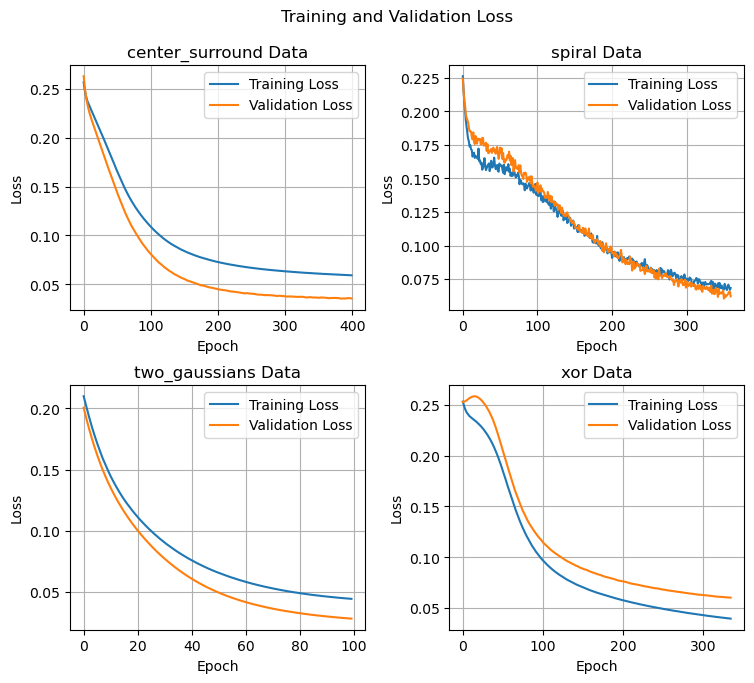

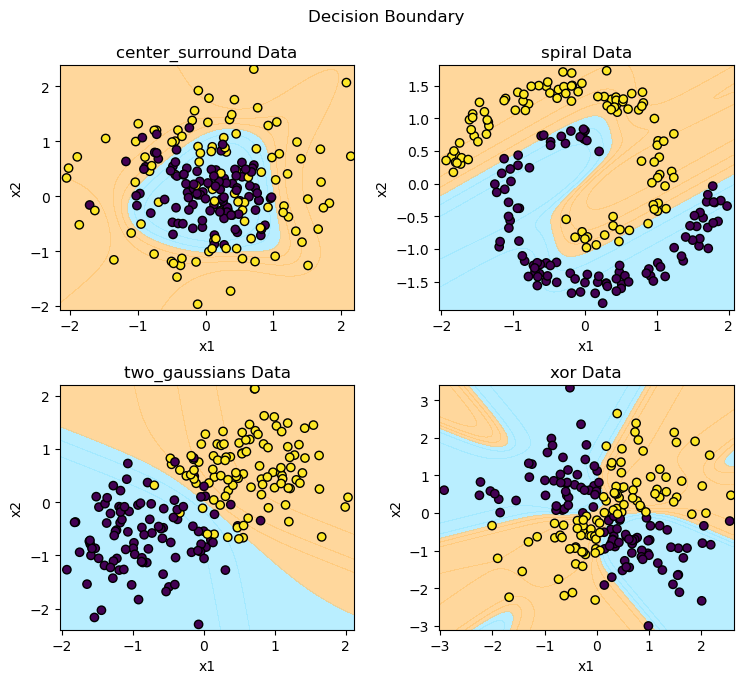

,Data,Accuracy,Loss,Batch Size,Shuffle,k,Learning Rate,Epochs
0,center_surround,0.765,0.187095,100,True,5,0.01,400
1,spiral,0.975,0.046614,120,True,9,0.01,360
2,two_gaussians,0.920,0.061494,100,True,3,0.01,100
3,xor,0.955,0.051156,100,True,5,0.01,335


In [20]:
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(8, 7))
fig_loss.suptitle('Training and Validation Loss')
fig_loss.tight_layout(pad=3.0)
fig_loss.subplots_adjust(top=0.90)

fig_decision, axes_decision = plt.subplots(2, 2, figsize=(8, 7))
fig_decision.suptitle('Decision Boundary')
fig_decision.tight_layout(pad=3.0)
fig_decision.subplots_adjust(top=0.90)

results = pd.DataFrame(columns=['Data', 'Accuracy', 'Loss', 'Batch Size', 'Shuffle', 'k', 'Learning Rate', 'Epochs'])

for idx in range(len(data_vec_str)):
    data_str = data_vec_str[idx]
    batch_size = data_params[data_str]['batch_size']
    shuffle = data_params[data_str]['shuffle']
    k = data_params[data_str]['k']
    lr = data_params[data_str]['lr']
    epochs = data_params[data_str]['epochs']
    print(f"Training on {data_str} data")
    
    # Process data
    train_data, train_target, valid_data, valid_target, test_data, test_target = process_data(
        data_vec[idx][0], data_vec[idx][1], data_vec[idx][2]
    )

    # Initialize manual model
    size_in = train_data.shape[1]
    size_out = 1
    model_manual = FeedForward(size_in, size_out, k)

    # Training
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        train_batches = create_batches(train_data, train_target, batch_size, shuffle)
        valid_batches = create_batches(valid_data, valid_target, batch_size, shuffle)
        
        # Train model on each batch
        epoch_train_loss = 0
        for x_batch, y_batch in train_batches:
            x_batch = x_batch.T
            y_batch = y_batch.reshape(1, -1)
            y_hat = model_manual.forward(x_batch)
            loss = compute_MSEloss(y_hat, y_batch)
            grads = backward(model_manual, x_batch, y_batch)
            update_parameters(model_manual, grads, lr, epoch + 1)
            epoch_train_loss += loss
        training_loss.append(epoch_train_loss / len(train_batches))
        
        # Evaluate model on validation data
        epoch_valid_loss = 0
        for x_batch, y_batch in valid_batches:
            x_batch = x_batch.T
            y_batch = y_batch.reshape(1, -1)
            y_hat = model_manual.forward(x_batch)
            loss = compute_MSEloss(y_hat, y_batch)
            epoch_valid_loss += loss
        validation_loss.append(epoch_valid_loss / len(valid_batches))

    # Plot training and validation loss
    axes_loss[idx//2, idx%2].plot(training_loss, label='Training Loss')
    axes_loss[idx//2, idx%2].plot(validation_loss, label='Validation Loss')
    axes_loss[idx//2, idx%2].set_xlabel('Epoch')
    axes_loss[idx//2, idx%2].set_ylabel('Loss')
    axes_loss[idx//2, idx%2].legend()
    axes_loss[idx//2, idx%2].grid(True)
    axes_loss[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

    # Evaluate model on test data
    accuracy, test_loss = evaluate_MSEmodel(model_manual, test_data, test_target)
    results.loc[idx] = [data_vec_str[idx], accuracy, test_loss, batch_size, shuffle, k, lr, epochs]

    #if x_test.shape[0] == 2:  # Check if the data has two features
    min1, max1 = test_data[:, 0].min() - 0.1, test_data[:, 0].max() + 0.1
    min2, max2 = test_data[:, 1].min() - 0.1, test_data[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(min1, max1, 0.05), np.arange(min2, max2, 0.05))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_T = grid.T
    z = model_manual.forward(grid_T).reshape(xx.shape)

    binary_cmap = colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axes_decision[idx//2, idx%2].contourf(xx, yy, z, cmap=binary_cmap, alpha=0.7)
    axes_decision[idx//2, idx%2].scatter(test_data[:, 0], test_data[:, 1], c=test_target, edgecolor='k')
    axes_decision[idx//2, idx%2].set_xlabel('x1')
    axes_decision[idx//2, idx%2].set_ylabel('x2')
    axes_decision[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

plt.show()
display(results)


## Regularizers

In [61]:
class Data(Dataset):
  def __init__(self, data, targets):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.labels = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

class FeedForwardRegularized(nn.Module):
    def __init__(self, size_in, size_out, k, device=device):
        super().__init__()
        self.input_to_hidden = nn.Linear(size_in, k)  # Hidden layer
        self.hidden_activation = nn.Tanh()  # Activation for hidden layer
        self.hidden_to_output = nn.Linear(k, size_out)  # Output layer
        self.output_activation = nn.Tanh()  # Activation for output layer
    
    def forward(self, x):
        x = self.hidden_activation(self.input_to_hidden(x))
        x = self.output_activation(self.hidden_to_output(x))
        return x

  
def train_model_with_regularization(model, dataloader, criterion, optimizer, lambda_l1norm, lambda_ortho, device):
  model.train()
  tot_train_loss = 0
  for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data).squeeze()
      mse_loss = criterion(output, target)

      #regularization
      l1_loss = lambda_l1norm * torch.sum(torch.abs(model.input_to_hidden.weight))
      weights = model.input_to_hidden.weight
      ortho_loss = lambda_ortho * torch.norm(weights @ weights.T - torch.eye(weights.size(0)).to(device)) 

      loss = mse_loss +l1_loss + ortho_loss
      loss.backward()
      optimizer.step()
      tot_train_loss += loss.item()
  return tot_train_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  targets = []
  predictions = []
  total_loss = 0
  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data).squeeze()
          loss = criterion(output, target)
          total_loss += loss.item()
          predictions.extend(output.cpu().numpy())
          targets.extend(target.cpu().numpy())
  # Calculate binary classification metrics
  predictions = np.array(predictions) > 0.5  # Threshold at 0.5
  accuracy = accuracy_score(targets, predictions)
  avg_loss = total_loss / len(dataloader)
  return predictions, accuracy, avg_loss

def process_data(train_df, valid_df, test_df, batch_size, shuffle):
  # set up data
  train_data_df = train_df.loc[:, train_df.columns != 'label']
  train_target_df = train_df['label']
  valid_data_df = valid_df.loc[:, valid_df.columns != 'label']
  valid_target_df = valid_df['label']
  test_data_df = test_df.loc[:, test_df.columns != 'label']
  test_target_df = test_df['label']

  len_features = len(train_data_df.columns)

  # fit and transform data
  sc = StandardScaler()
  train_data_df = sc.fit_transform(train_data_df)
  test_data_df = sc.transform(test_data_df)
  valid_data_df = sc.transform(valid_data_df)

  # set up and implement data loaders
  train_data = Data(train_data_df, train_target_df)
  valid_data = Data(valid_data_df, valid_target_df)
  test_data = Data(test_data_df, test_target_df)
  train_loader = DataLoader(train_data, batch_size, shuffle)
  valid_loader = DataLoader(valid_data, batch_size, shuffle)
  test_loader = DataLoader(test_data, batch_size, shuffle)

  return train_loader, valid_loader, test_loader, len_features, test_data_df, test_target_df

In [62]:
data_params = {
    'center_surround': {
        'batch_size': 100,
        'shuffle': True,
        'k': 5,
        'lr': 1e-2,
        'epochs': 400
    },
    'spiral': {
        'batch_size': 120,
        'shuffle': True,
        'k': 9,
        'lr': 1e-2,
        'epochs': 360
    },
    'two_gaussians': {
        'batch_size': 100,
        'shuffle': True,
        'k': 3,
        'lr': 1e-2,
        'epochs': 100
    },
    'xor': {
        'batch_size': 100,
        'shuffle': True,
        'k': 3,
        'lr': 1e-2,
        'epochs': 335
    }
} # k = {2, 3, 5, 7, 9}

Training on center_surround data
Training on spiral data
Training on two_gaussians data
Training on xor data


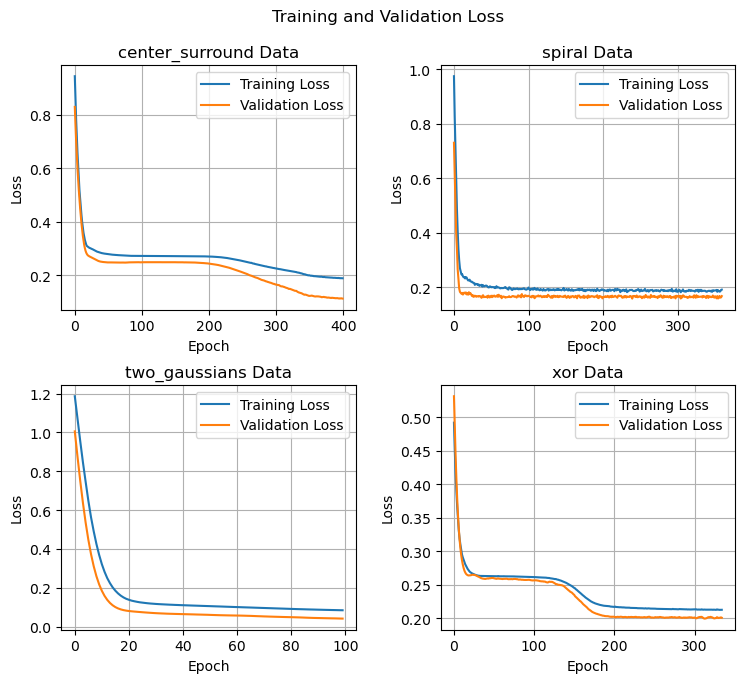

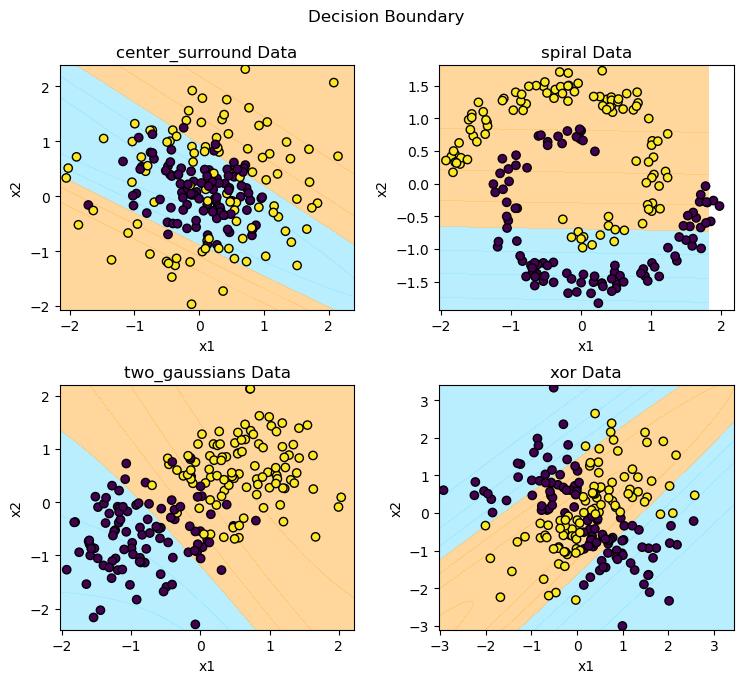

,Data,Accuracy,Loss,Batch Size,Shuffle,k,Learning Rate,Epochs
0,center_surround,0.685,0.207650,100,True,5,0.01,400
1,spiral,0.785,0.146046,120,True,9,0.01,360
2,two_gaussians,0.930,0.069143,100,True,3,0.01,100
3,xor,0.740,0.180622,100,True,3,0.01,335


In [64]:
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(8, 7))
fig_loss.suptitle('Training and Validation Loss')
fig_loss.tight_layout(pad=3.0)
fig_loss.subplots_adjust(top=0.90)

fig_decision, axes_decision = plt.subplots(2, 2, figsize=(8, 7))
fig_decision.suptitle('Decision Boundary')
fig_decision.tight_layout(pad=3.0)
fig_decision.subplots_adjust(top=0.90)

results = pd.DataFrame(columns=['Data', 'Accuracy', 'Loss', 'Batch Size', 'Shuffle', 'k', 'Learning Rate', 'Epochs'])


for idx in range(len(data_vec_str)):
    data_str = data_vec_str[idx]
    batch_size = data_params[data_str]['batch_size']
    shuffle = data_params[data_str]['shuffle']
    k = data_params[data_str]['k']
    lr = data_params[data_str]['lr']
    epochs = data_params[data_str]['epochs']
    print(f"Training on {data_str} data")
    
    # set up data
    train_loader, valid_loader, test_loader, len_features, test_data, test_target = \
        process_data(data_vec[idx][0], data_vec[idx][1], data_vec[idx][2], batch_size, shuffle)
    
    # set up model
    model = FeedForwardRegularized(len_features, 1, k).to(device)
    loss_fun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train model
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        avg_train_loss = train_model_with_regularization(model, train_loader, loss_fun, optimizer, lambda_l1norm = 0.01, lambda_ortho = 0.01, device=device)    
        _, accuracy, avg_valid_loss = evaluate_model(model, valid_loader, loss_fun, device)
        training_loss.append(avg_train_loss)
        validation_loss.append(avg_valid_loss)
        # if epoch % 100 == 0:
        #     print(f'Epoch {epoch}: Validation Accuracy: {accuracy:.4f}')

    # Plot training and validation loss
    axes_loss[idx//2, idx%2].plot(training_loss, label='Training Loss')
    axes_loss[idx//2, idx%2].plot(validation_loss, label='Validation Loss')
    axes_loss[idx//2, idx%2].set_xlabel('Epoch')
    axes_loss[idx//2, idx%2].set_ylabel('Loss')
    axes_loss[idx//2, idx%2].legend()
    axes_loss[idx//2, idx%2].grid(True)
    axes_loss[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

    # Evaluate model
    predictions, accuracy, avg_test_loss = evaluate_model(model, test_loader, loss_fun, device)
    results.loc[idx] = [data_vec_str[idx], accuracy, avg_test_loss, batch_size, shuffle, k, lr, epochs]

    # Plot decision boundaries (assumes two features)
    min1, max1 = test_data[:, 0].min()-0.1, test_data[:, 1].max()+0.1
    min2, max2 = test_data[:, 1].min()-0.1, test_data[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.arange(min1, max1, 0.05), np.arange(min2, max2, 0.05))
    grid = np.c_[xx.ravel(), yy.ravel()]
    z = model(torch.tensor(grid, dtype=torch.float32).to(device)).detach().cpu().numpy()
    zz = z.reshape(xx.shape)

    binary_cmap = colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axes_decision[idx//2, idx%2].contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)
    axes_decision[idx//2, idx%2].scatter(test_data[:,0], test_data[:,1], c=test_target, edgecolor='k')
    axes_decision[idx//2, idx%2].set_xlabel('x1')
    axes_decision[idx//2, idx%2].set_ylabel('x2')
    axes_decision[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

plt.show()
display(results)

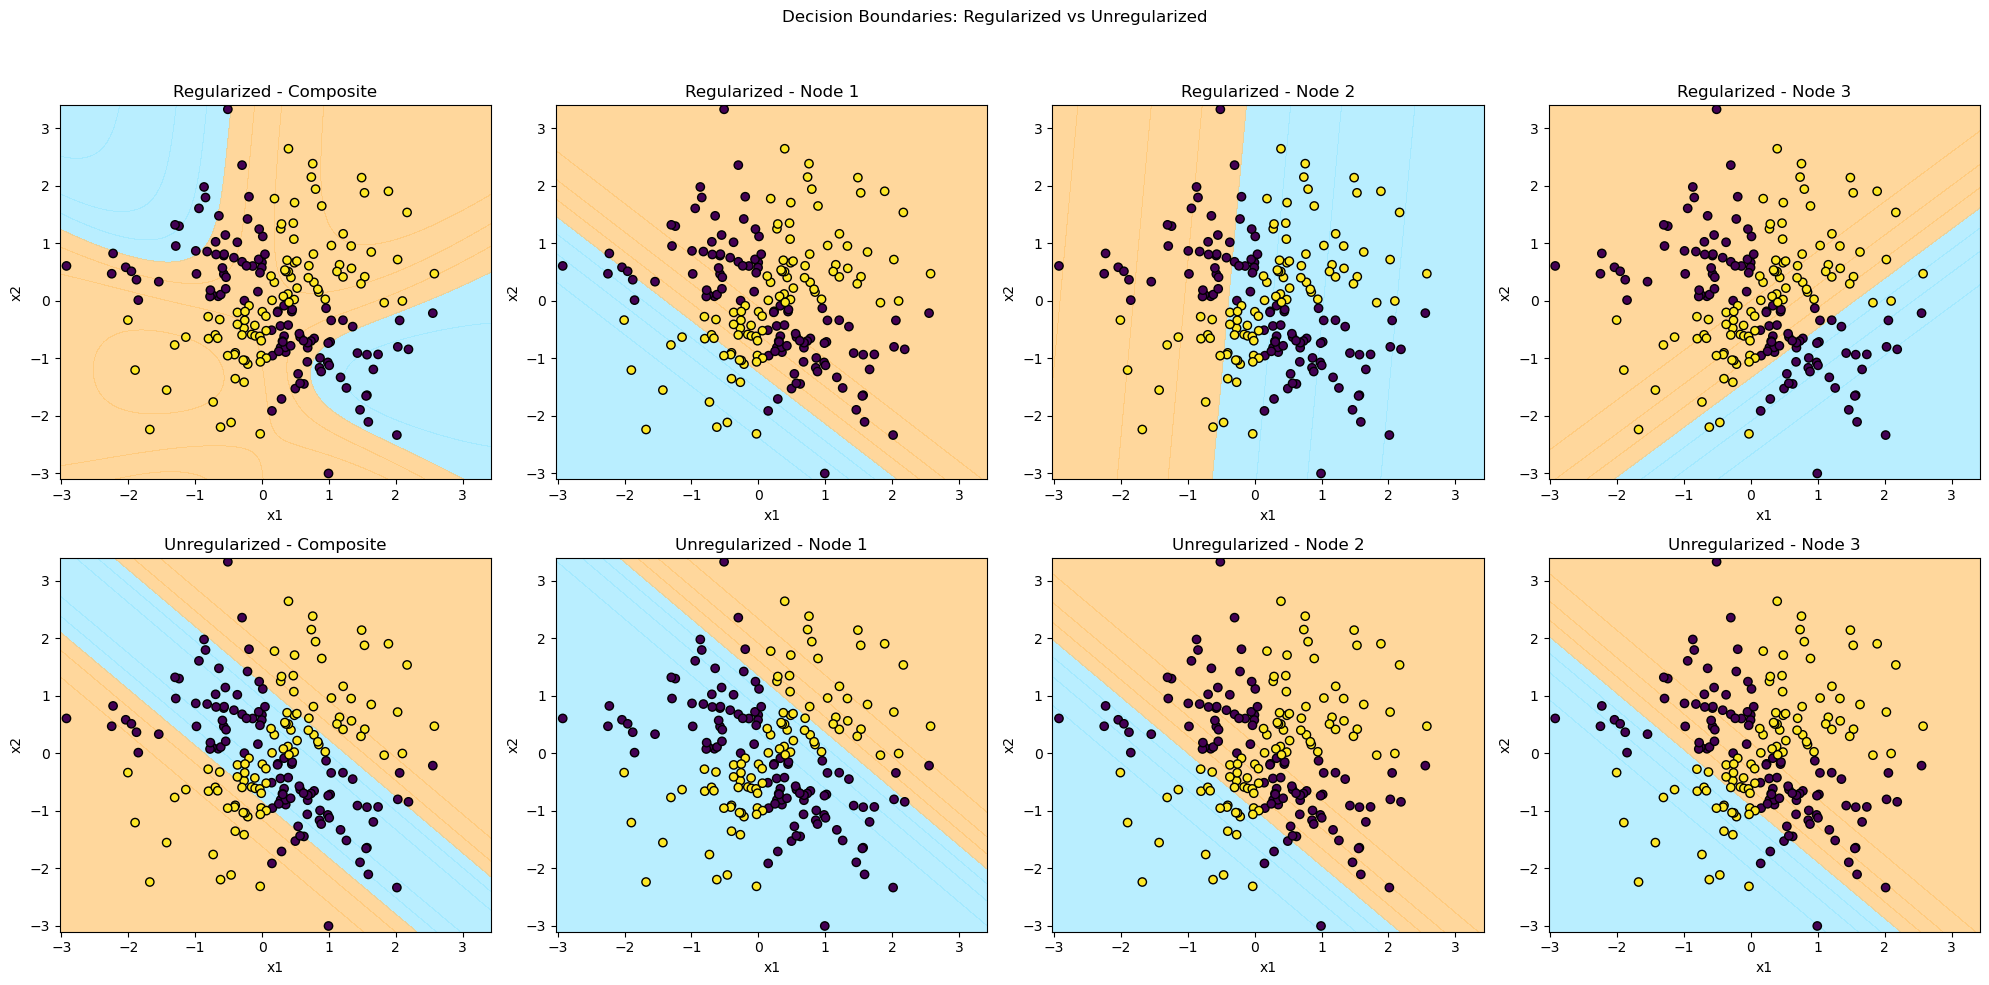

In [65]:
def plot_comparison_decision_boundaries(model_regularized, model_unregularized, dataset, grid, xx, yy, k, device):
    """
    Plots composite and individual decision boundaries for both regularized and unregularized models.

    """
    test_data, test_target = dataset

    fig, axes = plt.subplots(2, k + 1, figsize=(20, 10))
    fig.suptitle("Decision Boundaries: Regularized vs Unregularized")
    models = [model_regularized, model_unregularized]
    titles = ["Regularized", "Unregularized"]

    for row, (model, title) in enumerate(zip(models, titles)):
        
        z_composite = model(torch.tensor(grid, dtype=torch.float32).to(device)).detach().cpu().numpy().reshape(xx.shape)

        axes[row, 0].contourf(xx, yy, z_composite, cmap=binary_cmap, alpha=0.7)
        axes[row, 0].scatter(test_data[:, 0], test_data[:, 1], c=test_target, edgecolor='k')
        axes[row, 0].set_title(f"{title} - Composite")
        axes[row, 0].set_xlabel("x1")
        axes[row, 0].set_ylabel("x2")

        hidden_weights = model.input_to_hidden.weight.detach().cpu().numpy()
        hidden_biases = model.input_to_hidden.bias.detach().cpu().numpy()

        for i in range(k):
            z_hidden = np.tanh(np.dot(grid, hidden_weights[i]) + hidden_biases[i]).reshape(xx.shape)

            axes[row, i + 1].contourf(xx, yy, z_hidden, cmap=binary_cmap, alpha=0.7)
            axes[row, i + 1].scatter(test_data[:, 0], test_data[:, 1], c=test_target, edgecolor='k')
            axes[row, i + 1].set_title(f"{title} - Node {i + 1}")
            axes[row, i + 1].set_xlabel("x1")
            axes[row, i + 1].set_ylabel("x2")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_comparison_decision_boundaries(model_regularized, model_unregularized, (test_data, test_target), grid, xx, yy, k, device)
